# 02_feature_engineering.ipynb

## Imports & Load Data

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

df = pl.read_parquet("../data/processed/train_initial.parquet")

df = df.with_columns(pl.col("date").cast(pl.Date))

print(f"Data Loaded: {df.height} rows")
display(df.head(3))

Data Loaded: 3000888 rows


id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster
i64,date,i64,str,f64,i64,f64,str,str,str,i64
0,2013-01-01,1,"""AUTOMOTIVE""",0.0,0,93.14,"""Quito""","""Pichincha""","""D""",13
1,2013-01-01,1,"""BABY CARE""",0.0,0,93.14,"""Quito""","""Pichincha""","""D""",13
2,2013-01-01,1,"""BEAUTY""",0.0,0,93.14,"""Quito""","""Pichincha""","""D""",13


## Target Analysis

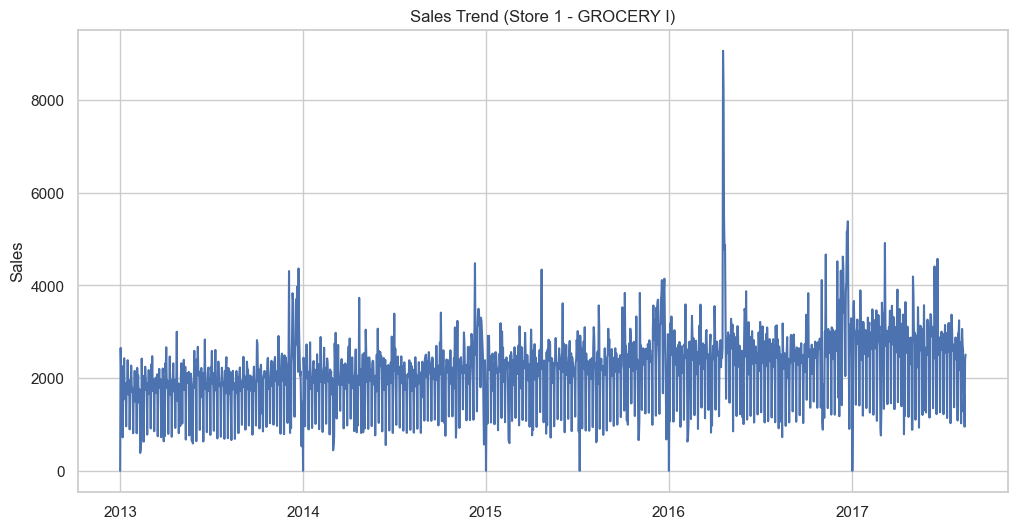

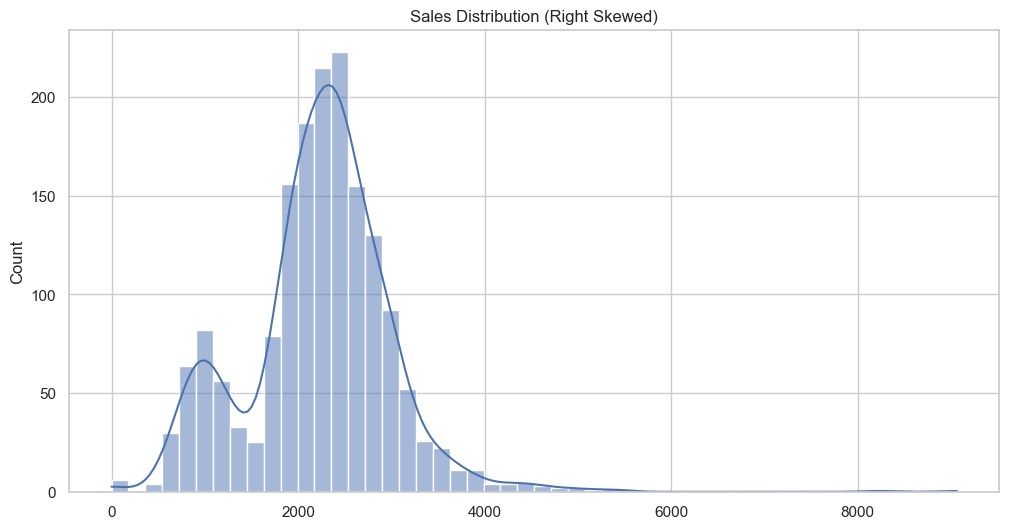

In [2]:
sample_df = df.filter(
    (pl.col("store_nbr") == 1) &
    (pl.col("family") == "GROCERY I")
).sort("date")

# 1. Time Series Graph
plt.figure()
plt.plot(sample_df["date"], sample_df["sales"])
plt.title("Sales Trend (Store 1 - GROCERY I)")
plt.ylabel("Sales")
plt.show()

# 2. Distritbution graph
plt.figure()
sns.histplot(sample_df["sales"], bins=50, kde=True)
plt.title("Sales Distribution (Right Skewed)")  # Long Tail
plt.show()



觀察: 銷量分佈是高度右偏的 (Right Skewed)。 <br>
結論: 這驗證了為什麼我們應該針對 Log(Sales) 進行優化，或者使用 reg:squaredlogerror。

## Lag Features

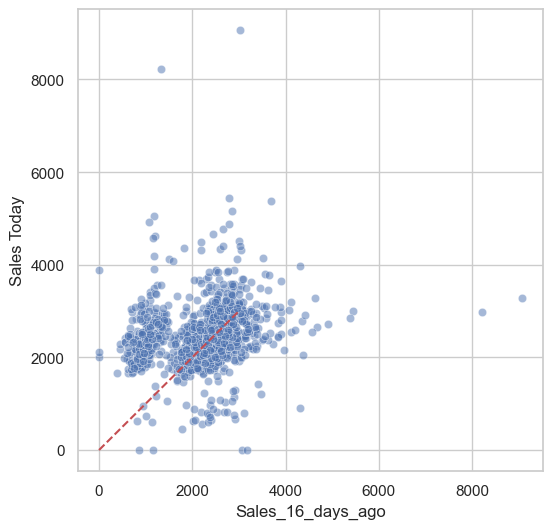

In [4]:
df_lag = df.with_columns([
    pl.col("sales").shift(16).over(["store_nbr", "family"]).alias("lag_16"),
    pl.col("sales").shift(30).over(["store_nbr", "family"]).alias("lag_30")
])

# Correlation (visualization)
sample_lag = df_lag.filter(
    (pl.col("store_nbr") == 1) & (pl.col("family") == "GROCERY I")
).drop_nulls()

plt.figure(figsize=(6, 6))
sns.scatterplot(x=sample_lag["lag_16"], y=sample_lag["sales"], alpha=0.5)
plt.xlabel("Sales_16_days_ago")
plt.ylabel("Sales Today")
plt.plot([0, 3000], [0, 3000], 'r--') # 45 degree reference
plt.show()

觀察: 點的分佈呈現明顯的正相關 (在對角線附近)。<br>
結論: Lag-16 是一個強特徵 (Strong Predictor)。

## Rolling Statistics

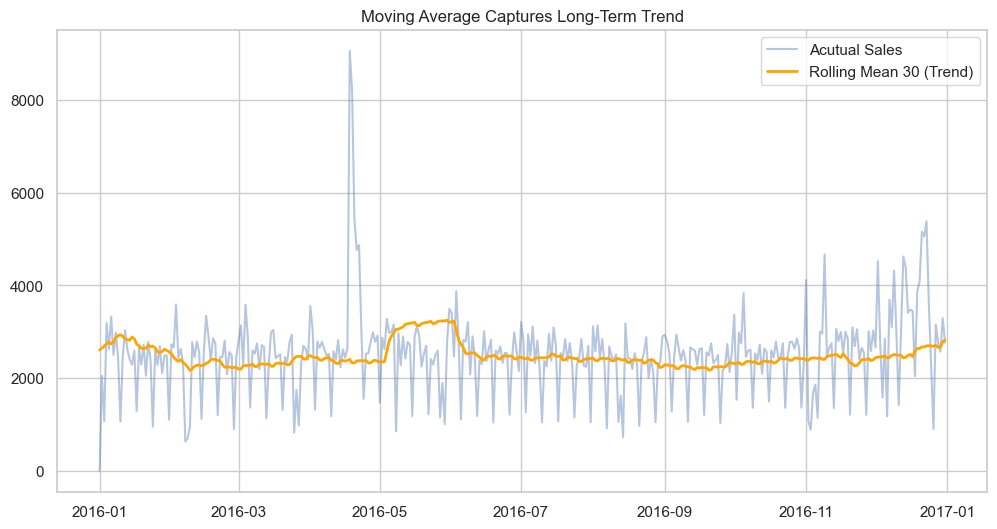

In [5]:
df_roll = df_lag.with_columns([
    pl.col("sales").shift(16).rolling_mean(window_size=30).over(["store_nbr", "family"]).alias("rolling_mean_30"),
    pl.col("sales").shift(16).rolling_mean(window_size=60).over(["store_nbr", "family"]).alias("rolling_mean_60")
])
# Must shidt(16) before rolling to prevent from using future data -> Leakage

sample_roll = df_roll.filter(
    (pl.col("store_nbr") == 1) & (pl.col("family") == "GROCERY I") & 
    (pl.col("date").dt.year() == 2016)
).sort("date")

plt.figure()
plt.plot(sample_roll["date"], sample_roll["sales"], label="Acutual Sales", alpha=0.4)
plt.plot(sample_roll["date"], sample_roll["rolling_mean_30"], label="Rolling Mean 30 (Trend)", linewidth=2, color='orange')
plt.legend()
plt.title("Moving Average Captures Long-Term Trend")
plt.show()

觀察: 橘線 (Rolling Mean) 平滑了每日的波動，反映了基本的銷售水平。<br>
結論: 這能幫助模型區分「異常波動」與「基本盤」。

## Seasonality

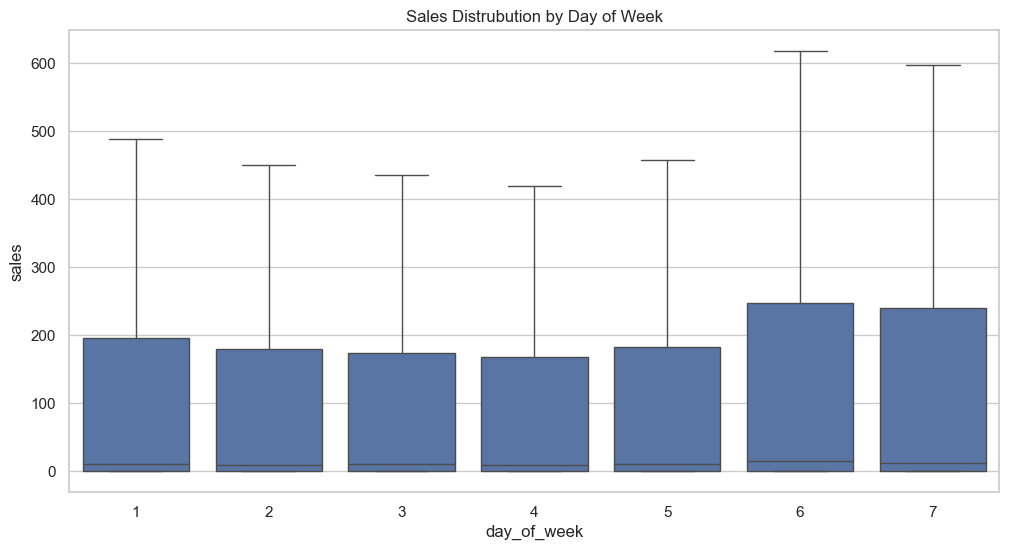

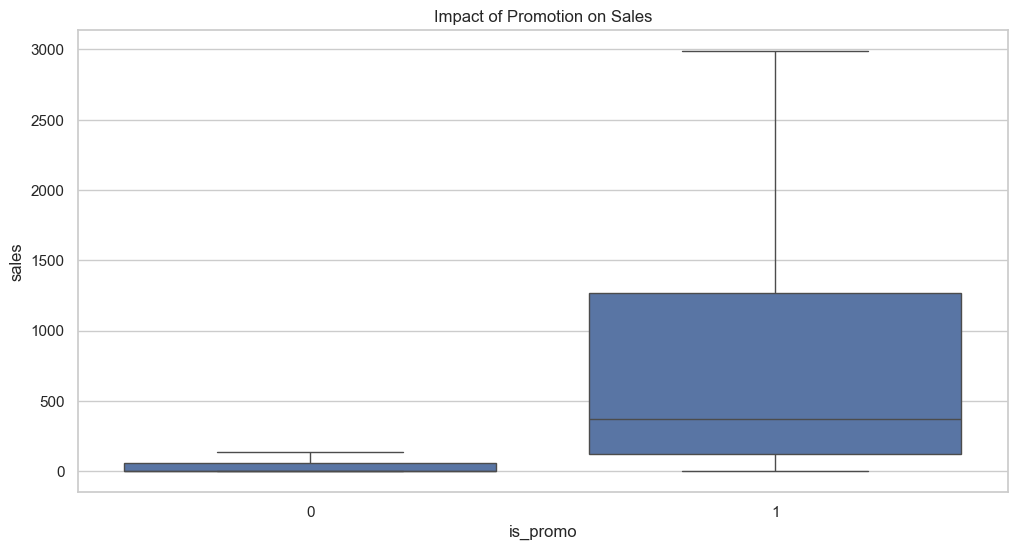

In [10]:
df_feat = df_roll.with_columns([
    pl.col("date").dt.weekday().alias("day_of_week"),  # 1=Mon, 7=Sun
    (pl.col("onpromotion") > 0).cast(pl.Int8).alias("is_promo")
])

# Impact of day of week - Boxplot
plt.figure()
sns.boxplot(data=df_feat.to_pandas(), x="day_of_week", y="sales", showfliers=False)
plt.title("Sales Distrubution by Day of Week")
plt.show()

# Impact of promotion - boxplot
plt.figure()
sns.boxplot(data=df_feat.to_pandas(), x="is_promo", y="sales", showfliers=False)
plt.title("Impact of Promotion on Sales")
plt.show()

觀察: 週末 (6, 7) 的中位數明顯較高；有促銷 (1) 的銷量顯著高於無促銷。 <br>
結論: day_of_week 和 onpromotion 是關鍵特徵。

## Check results

In [11]:
# Delete null value generated by Lag/Rolling
df_final = df_feat.drop_nulls()

print(f"Final Data Shape: {df_final.shape}")

Final Data Shape: (2047518, 17)
